<a href="https://colab.research.google.com/github/Ga-Young-Ahn/Study/blob/main/CH4_%EC%9E%90%EC%97%B0%EC%96%B4_%EC%B2%98%EB%A6%AC%EB%A5%BC_%EC%9C%84%ED%95%9C_%ED%94%BC%EB%93%9C_%ED%8F%AC%EC%9B%8C%EB%93%9C_%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4 자연어 처리를 위한 피드 포워드 신경망
## 4.1 다층 퍼셉트론
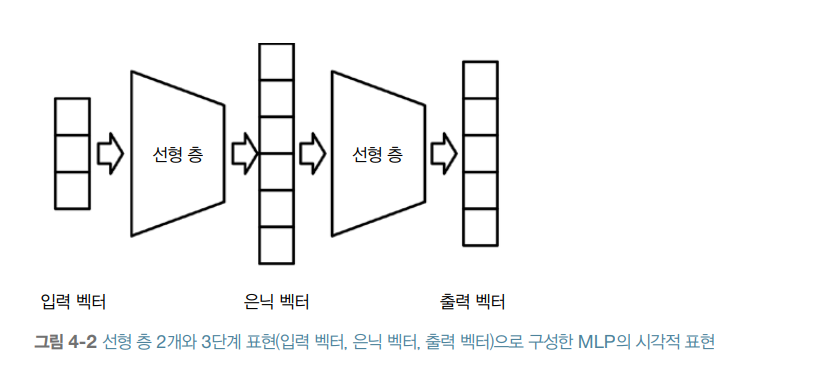

In [ ]:
### 파이토치를 사용한 MLP
import torch.nn as nn
import torch.nn.functional as F

class MultilayerPerceptron(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    """
    매개변수
        input_dim (int): 입력 벡터 크기
        hidden_dim (int): 첫 번째 Linear 층의 출력 크기
        output_dim (int): 두 번째 Linear 층의 출력 크기
    """
    super(MultilayerPerceptron, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)

  
  def forward(self, x_in, apply_softmax=False):
    """
    MLP의 정방향 계산
    매개변수
        x_in (torch.Tensor): 입력 데이터 텐서, x_in.shape는 (batch, input_dim)이다.
        apply_softmax (bool): 소프트맥스 활성화 함수를 위한 플래그, 크로스 엔트로피 손실 사용하려면 False
    반환값
        결과 텐서. tensor.shape는 (batch, output_dim)이다.
    """
    intermediate = F.relu(self.fc1(x_in))
    output = self.fc2(intermediate)

    if apply_softmax:
      output = F.softmax(output, dim=1)
    return output

In [ ]:
### MLP 객체 생성
batch_size = 2  #한 번에 입력할 샘플 개수
input_dim = 3
hidden_dim = 100
output_dim = 4

# 모델 생성
mlp = MultilayerPerceptron(input_dim, hidden_dim, output_dim)
print(mlp)

MultilayerPerceptron(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)


In [ ]:
### 랜덤한 입력으로 MLP 테스트하기
import torch
def describe(x):
  print("타입: {}".format(x.type()))
  print("크기: {}".format(x.shape))
  print("값: \n{}".format(x))

x_input = torch.rand(batch_size, input_dim)
describe(x_input)

타입: torch.FloatTensor
크기: torch.Size([2, 3])
값: 
tensor([[0.2506, 0.5390, 0.9070],
        [0.1977, 0.1565, 0.6408]])


In [ ]:
y_output = mlp(x_input, apply_softmax=False)
describe(y_output)

타입: torch.FloatTensor
크기: torch.Size([2, 4])
값: 
tensor([[-0.1105, -0.2299, -0.3040, -0.0216],
        [-0.0737, -0.2339, -0.1928,  0.0059]], grad_fn=<AddmmBackward0>)


In [ ]:
### MLP 분류기로 확률 출력하기 (apply_softmax=True)
y_output = mlp(x_input, apply_softmax=True)
describe(y_output)

타입: torch.FloatTensor
크기: torch.Size([2, 4])
값: 
tensor([[0.2628, 0.2333, 0.2166, 0.2873],
        [0.2616, 0.2229, 0.2322, 0.2833]], grad_fn=<SoftmaxBackward0>)


## 4.2 예제: MLP로 성씨 분류하기

MLP 구현과 훈련은 3장 퍼셉트론 구현과 훈련의 반복임

In [ ]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

In [ ]:
class SurnameDataset(Dataset):
  def __getitem__(self, index):
    row = self._target_df.iloc[index]
    surname_vector = self._vectorizer.vectorize(row.surname)
    nationality_index = self._vectorizer.nationality_vocab.lookup_token(row.nationality)

    return {'x_surname':surname_vector,
            'y_nationality':nationality_index}

**데이터 벡터 변환 클래스 - Vocabulary**

In [ ]:
### 매핑을 위해 텍스트를 처리하고 어휘 사전을 만드는 클래스 
class Vocabulary(object):
  def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
    if token_to_idx is None:
      token_to_idx = {}
    self._token_to_idx = token_to_idx
    
    self._idx_to_token = {idx: token 
                          for token, idx in self._token_to_idx.items()}

    self._add_unk = add_unk
    self._unk_token = unk_token

    self.unk_index = -1
    if add_unk:
      self.unk_index = self.add_token(unk_token)

    
  def to_serializable(self): #직렬화할 수 있는 딕셔너리를 반환
    return {'token_to_idx':self._token_to_idx,
            'add_unk':self._add_unk,
            'unk_token':self._unk_token}

  
  @classmethod
  def from_serializable(cls, contents): #직렬화된 딕셔너리에서 Vocabulary 객체 만듦
    return cls(**contents)

  
  def add_token(self, token): #토큰을 기반으로 매핑 딕셔너리를 업데이트함
    try:
      index = self._token_to_idx[token]
    except KeyError:
      index = len(self._token_to_idx)
      self._token_to_idx[token] = index
      self._idx_to_token[index] = token
    return index


  def add_many(self, tokens): #토큰 리스트를 Vocabulary에 추가함.
    return [self.add_token(token) for token in tokens]


  def lookup_token(self, token): #토큰에 대응하는 인덱스 추출, 토큰이 없으면 UNK 인덱스 반환
    if self.unk_index >= 0:
      return self._token_to_idx.get(token, self.unk_index)
    else:
      return self._token_to_idx[token]


  def lookup_index(self, index): #인덱스에 해당하는 토큰을 반환
    if index not in self._idx_to_token:
      raise KeyError("Vocabulary에 인덱스(%d)가 없습니다." % index)
    return self._idx_to_token[index]

  
  def __str__(self):
    return "<Vocabulary(size=%d)>" % len(self)

  
  def __len__(self):
    return len(self._token_to_idx)

**데이터 벡터 변환 클래스 - SurnameVectorizer**

In [ ]:
### 어휘 사전을 생성하고 관리함
class SurnameVecorizer(object):
  def __init__(self, surname_vocab, nationality_vocab):
    self.surname_vocab = surname_vocab
    self.nationality_vocab = nationality_vocab

  
  def vectorize(self, surname): #성씨에 대한 원-핫 벡터를 만듭니다
    vocab = self.surname_vocab
    one_hot = np.zeros(len(vocab), dtype=np.float32)
    for token in surname:
      one_hot[vocab.lookup_token(token)] = 1
    return one_hot

  
  @classmethod
  def from_dataframe(cls, surname_df): #데이터셋 데이터프레임에서 Vectorizer 객체 만듦
    surname_vocab = Vocabulary(unk_token="@")
    nationality_vocab = Vocabulary(add_unk=False)

    for index, row in surname_df.iterrows():
      for letter in row.surname:
        surname_vocab.add_token(letter)
      nationality_vocab.add_token(row.nationality)

    return cls(surname_vocab, nationality_vocab)

  
  @classmethod
  def from_serializable(cls, contents):
    surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
    nationality_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
    return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab)

  
  def to_serializable(self):
    return {'surname_vocab':self.surname_vocab.to_serializable(),
            'nationality_vocab':self.nationality_vocab.to_serializable()}


**Dataset**

In [ ]:
class SurnameDataset(Dataset):
  def __init__(self, surname_df, vectorizer):
    self.surname_df = surname_df
    self._vectorizer = vectorizer

    self.train_df = self.surname_df[self.surname_df.split=='train']
    self.train_size = len(self.train_df)

    self.val_df = self.surname_df[self.surname_df.split=='val']
    self.validation_size = len(self.val_df)

    self.test_df = self.surname_df[self.surname_df.split=='test']
    self.test_size = len(self.test_df)

    self._lookup_dict = {'train': (self.train_df, self.train_size),
                          'val': (self.val_df, self.validation_size),
                          'test': (self.test_df, self.test_size)}

    self.set_split('train')

    # 클래스 가중치
    class_counts = surname_df.nationality.value_counts().to_dict()
    def sort_key(item):
      return self._vectorizer.nationality_vocab.lookup_token(item[0])
    sorted_counts = sorted(class_counts.items(), key=sort_key)
    frequencies = [count for _, count in sorted_counts]
    self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

  
  @classmethod
  def load_dataset_and_make_vectorizer(cls, surname_csv): 
    #데이터셋을 로드하고 새로운 SurnameVectorizer 객체 만듦
    surname_df = pd.read_csv(surname_csv)
    train_surname_df = surname_df[surname_df.split=='train']
    return cls(surname_df, SurnameVecorizer.from_dataframe(train_surname_df))


  @classmethod
  def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath): 
    #캐시된 SurnameVectorizer 객체 재사용 할 때 쓰임
    surname_df = pd.read_csv(surname_csv)
    vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
    return cls(surname_df, vectorizer)


  @staticmethod
  def load_vectorizer_only(vectorizer_filepath): 
    #파일에서 SurnameVectorizer 객체를 로드하는 정적 메서드
    with open(vectorizer_filepath) as fp:
      return SurnameVecorizer.from_serializable(json.load(fp))


  def save_vectorizer(self, vectorizer_filepath):
    #SurnameVectorizer 객체를 json 형태로 디스크에 저장
    with open(vectorizer_filepath, 'w') as fp:
      json.dump(self._vectorizer.to_serializable(), fp)

    
  def get_vectorizer(self): #벡터 변환 객체를 반환
    return self._vectorizer


  def set_split(self, split='train'): #데이터프레임의 열을 사용해 분할 세트 선택
    self._target_split = split
    self._target_df, self._target_size = self._lookup_dict[split]


  def __len__(self):
    return self._target_size


  def __getitem__(self, index):
    row = self._target_df.iloc[index]
    surname_vector = self._vectorizer.vectorize(row.surname)
    nationality_index = self._vectorizer.nationality_vocab.lookup_token(row.nationality)

    return {'x_surname':surname_vector, 
            'y_nationality':nationality_index}


  def get_num_batches(self, batch_size): 
    #배치 크기가 주어지면 데이터셋으로 만들 수 있는 배치 개수 반환
    return len(self)//batch_size


def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device='cpu'):
  #파이토치 DataLoader를 감싸고 있는 제너레이터 함수
  #각 텐서를 지정된 장치로 이동함. 
  dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=shuffle, drop_last=drop_last)
  for data_dict in dataloader:
    out_data_dict = {}
    for name, tensor in data_dict.items():
      out_data_dict[name] = data_dict[name].to(device)
    yield out_data_dict

**모델 - SurnameClassifier**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

### 성씨 분류를 위한 MLP
class SurnameClassifier(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(SurnameClassifier, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)

  
  def forward(self, x_in, apply_softmax=False): #MLP의 정방향 계산
    intermediate_vector = F.relu(self.fc1(x_in))
    prediction_vector = self.fc2(intermediate_vector)

    if apply_softmax:
      prediction_vector = F.softmax(prediction_vector, dim=1)

    return prediction_vector

### 4.2.4 모델 훈련

In [ ]:
### 헬퍼 함수
def make_train_state(args):
  return {'stop_early': False,
          'early_stopping_step': 0,
          'early_stopping_best_val': 1e8,
          'learning_rate': args.learning_rate,
          'epoch_index': 0,
          'train_loss': [],
          'train_acc': [],
          'val_loss': [],
          'val_acc': [],
          'test_loss': -1,
          'test_acc': -1,
          'model_filename': args.model_state_file}
  

def update_train_state(args, model, train_state):
  #훈련 상태를 업데이트함

  #적어도 한 번 모델을 저장함
  if train_state['epoch_index'] == 0:
    torch.save(model.state_dict(), train_state['model_filename'])
    train_state['stop_early'] = False

  #성능이 향상되면 모델을 저장함
  elif train_state['epoch_index'] >= 1:
    loss_tm1, loss_t = train_state['val_loss'][-2:]

      # 손실이 나빠지면
    if loss_t >= train_state['early_stopping_best_val']:
        # 조기 종료 단계 업데이트
        train_state['early_stopping_step'] += 1
    # 손실이 감소하면
    else:
        # 최상의 모델 저장
        if loss_t < train_state['early_stopping_best_val']:
            torch.save(model.state_dict(), train_state['model_filename'])

        # 조기 종료 단계 재설정
        train_state['early_stopping_step'] = 0

    # 조기 종료 여부 확인
    train_state['stop_early'] = \
        train_state['early_stopping_step'] >= args.early_stopping_criteria

  return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
### 유틸리티
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [ ]:
### MLP 기반의 성씨 분류기를 위한 하이퍼파라미터와 프로그램 설정
args = Namespace(
    surname_csv = '/content/drive/MyDrive/파이토치로 배우는 자연어 처리/surnames_with_splits.csv',
    vectorizer_file = 'vectorizer.json',
    model_state_file = 'model.pth',
    save_dir = '/content/drive/MyDrive/파이토치로 배우는 자연어 처리/surname_mlp',
    #모델 하이퍼파라미터
    hidden_dim = 300,
    #훈련 하이퍼파라미터
    seed = 1337,
    num_epochs = 100,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    batch_size = 64,
    #실행 옵션
    cuda=False,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

In [ ]:
if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("CUDA 사용여부: {}".format(args.cuda))

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	/content/drive/MyDrive/파이토치로 배우는 자연어 처리/surname_mlp/vectorizer.json
	/content/drive/MyDrive/파이토치로 배우는 자연어 처리/surname_mlp/model.pth
CUDA 사용여부: False


In [ ]:
### 초기화
# 만약 코랩에서 실행하는 경우 아래 코드를 실행하여 전처리된 라이트 버전의 데이터를 다운로드하세요.
!mkdir data
!wget https://git.io/JtaFp -O data/download.py
!wget https://git.io/Jtabe -O data/get-all-data.sh
!chmod 755 data/get-all-data.sh
%cd data
!./get-all-data.sh
%cd .

--2021-12-14 10:38:59--  https://git.io/JtaFp
Resolving git.io (git.io)... 18.205.36.100, 54.162.128.250, 54.157.58.70, ...
Connecting to git.io (git.io)|18.205.36.100|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_4/4_2_mlp_surnames/data/download.py [following]
--2021-12-14 10:38:59--  https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_4/4_2_mlp_surnames/data/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572 (1.5K) [text/plain]
Saving to: ‘data/download.py’

data/download.py    100%[===================>]   1.54K  --.-KB/s    in 0s      

2021-12-14 10:38:59 (18.7 MB/s) - ‘data/download.py’ saved [1572/1572]

--202

In [ ]:
if args.reload_from_files:
  print('로딩!')
  dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                            arges.vectorizer_file)
else:
  print('새로 만들기!')
  dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
  dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab),
                               hidden_dim=args.hidden_dim,
                               output_dim=len(vectorizer.nationality_vocab))

새로 만들기!


**훈련 반복**

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5, patience=1)

train_state = make_train_state(args)
epoch_bar = tqdm.notebook.tqdm(desc='training routine',
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size), 
                               position=1, 
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size), 
                             position=1, 
                             leave=True)

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
try:
  for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index

    #훈련 세트에 대한 순회
    #훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
      #훈련 과정은 5단계
      #-------------------------------------------
      #단계 1. 그레이디언트를 0으로 초기화함
      optimizer.zero_grad()
      #단계 2. 출력을 계산함
      y_pred = classifier(batch_dict['x_surname'])
      #단계 3. 손실을 계산함
      loss = loss_func(y_pred, batch_dict['y_nationality'])
      loss_t = loss.item()
      running_loss += (loss_t - running_loss) / (batch_index + 1)
      #단계 4. 손실을 사용해 그레이디언트 계산
      loss.backward()
      #단계 5. 옵티마이저로 가중치 업데이트
      optimizer.step()
      #--------------------------------------------

      #정확도를 계산함
      acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
      running_acc += (acc_t - running_acc) / (batch_index + 1)

      #진행 바 업데이트
      train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
      train_bar.update()

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)


    #검증 세트에 대한 순회
    #검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
      #단계 1. 출력을 계산함
      y_pred = classifier(batch_dict['x_surname'])
      #단계 2. 손실을 계산함
      loss = loss_func(y_pred, batch_dict['y_nationality'])
      loss_t = loss.to('cpu').item()
      running_loss += (loss_t - running_loss) / (batch_index + 1)
      #단계 3. 정확도를 계산함
      acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
      running_acc += (acc_t - running_acc) / (batch_index + 1)
      val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
      val_bar.update()

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    train_state = update_train_state(args=args, model=classifier, train_state=train_state)
    
    scheduler.step(train_state['val_loss'][-1])
    if train_state['stop_early']:
      break
    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()
except KeyboardInterrupt:
  print('Exiting loop')

In [ ]:
### 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_fun = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)

running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
  #출력을 계산
  y_pred = classifier(batch_dict['x_surname'])

  #손실을 계산
  loss = loss_func(y_pred, batch_dict['y_nationality'])
  loss_t = loss.item()
  running_loss += (loss_t - running_loss) / (batch_index + 1)

  #정확도를 계산
  acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
  running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [ ]:
print('테스트 손실: {}'.format(train_state['test_loss']))
print('테스트 정확도: {}'.format(train_state['test_acc']))

테스트 손실: 1.8147725248336792
테스트 정확도: 49.37500000000001


### 4.2.5 모델 평가와 예측
새로운 성씨 분류하기

In [ ]:
### 기존 모델을 사용한 추론: 주어진 이름의 국적 예측하기
def predict_nationality(surname, classifier, vectorizer):
  vectorized_surname = vectorizer.vectorize(surname)
  vectorized_surname = torch.tensor(vectorized_surname).view(1,-1)
  result = classifier(vectorized_surname, apply_softmax=True)

  probability_values, indices = result.max(dim=1)
  index = indices.item()

  predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
  probability_values = probability_values.item()

  return {'nationality':predicted_nationality, 'probability':probability_values}

In [ ]:
new_surname = input('분류하려는 성씨를 입력하세요: ')
classifier = classifier.to('cpu')
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['nationality'],
                                    prediction['probability']))

분류하려는 성씨를 입력하세요: Macmahan
Macmahan -> Scottish (p=0.35)


In [ ]:
predict_nationality('McMahan', classifier, vectorizer)

{'nationality': 'Irish', 'probability': 0.45474720001220703}

In [ ]:
### 새로운 성씨에 대해 최상위 k개 예측 만들기
def predict_topk_nationality(name, classifier, vectorizer, k=5):
  vectorized_name = vectorizer.vectorize(name)
  vectorized_name = torch.tensor(vectorized_name).view(1,-1)
  prediction_vector = classifier(vectorized_name, apply_softmax=True)
  probability_values, indices = torch.topk(prediction_vector, k=k)

  #반환되는 크기는 (1,k)
  probability_values = probability_values.detach().numpy()[0]
  indices = indices.detach().numpy()[0]

  results = []
  for prob_value, index in zip(probability_values, indices):
    nationality = vectorizer.nationality_vocab.lookup_index(index)
    results.append({'nationality':nationality, 'probability':prob_value})

  return results

In [ ]:
predict_topk_nationality('McMahan', classifier, vectorizer, k=6)

[{'nationality': 'Irish', 'probability': 0.4547472},
 {'nationality': 'Scottish', 'probability': 0.21228652},
 {'nationality': 'Czech', 'probability': 0.08587457},
 {'nationality': 'Vietnamese', 'probability': 0.045745913},
 {'nationality': 'German', 'probability': 0.045223072},
 {'nationality': 'Russian', 'probability': 0.043956373}]

In [ ]:
x = torch.rand(2)
x

tensor([0.4637, 0.2470])

In [ ]:
x.view(1,-1)

tensor([[0.0299, 0.3609]])

### 4.2.6 MLP 규제: 가중치 규제와 구조적 규제(또는 드롭아웃)
드롭아웃은 훈련 시에만 적용하고 평가할때는 적용하지 않아야 함

In [ ]:
### 드롭아웃을 적용한 MLP
import torch.nn as nn
import torch.nn.functional as F

class MultilayerPerceptron(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(MultilayerPerceptron, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)
  
  def forward(self, x_in, apply_softmax=False):
    intermediate = F.relu(self.fc1(x_in))
    output = self.fc2(F.dropout(intermediate, p=0.5))

    if apply_softmax:
      output = F.softmax(output, dim=1)
    return output

## 4.3 합성곱 신경망
### 4.3.2 파이토치로 CNN 구현하기

특성 벡터를 만들기 위한 설계 사항들을 반복하여 결정함.  
그 첫 번째 단계는 Conv1d 클래스의 객체를 3차원 데이터 텐서에 적용하는 것.

In [ ]:
### 인공 데이터와 Conv1d 클래스
from torch.nn import Conv1d

batch_size = 2
one_hot_size = 10
sequence_width = 7
data = torch.randn(batch_size, one_hot_size, sequence_width)
conv1 = Conv1d(in_channels=one_hot_size, out_channels=16, kernel_size=3)
intermediate1 = conv1(data)
print(data.size())
print(intermediate1.size())

torch.Size([2, 10, 7])
torch.Size([2, 16, 5])


In [ ]:
### 데이터에 반복 적용한 합성곱
conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)

intermediate2 = conv2(intermediate1)
intermediate3 = conv3(intermediate2)

print(intermediate2.size())
print(intermediate3.size())


torch.Size([2, 32, 3])
torch.Size([2, 64, 1])


In [ ]:
y_output = intermediate3.squeeze()   #불필요한 size=1 차원을 제거함
print(y_output.size())   #특성 벡터를 Linear층과 같은 다른 신경망 구성 요소에 사용하여 예측 벡터를 만들 수 있음

torch.Size([2, 64])


In [ ]:
### 특성 벡터를 줄이는 방법 2
# view() 메서드를 사용해 모든 벡터를 하나의 벡터로 펼침
print(intermediate1.view(batch_size, -1).size())

### 특성 벡터를 줄이는 방법 3
# 수학 연산을 사용해 정보를 벡터로 요약함 (가장 많이 쓰는 건 산술 평균)
print(torch.mean(intermediate1, dim=2).size())

torch.Size([2, 80])
torch.Size([2, 16])


## 4.4 예제: CNN으로 성씨 분류하기
### 4.4.2 Vocabulary, Vectorizer, DataLoader
Vectorizer의 vectorize 메서드를 cnn모델에 맞게 바꿔야 함

In [ ]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

In [ ]:
### 어휘 사전을 생성하고 관리함
class SurnameVecorizer(object):
  def __init__(self, surname_vocab, nationality_vocab):
    self.surname_vocab = surname_vocab
    self.nationality_vocab = nationality_vocab

  
  def vectorize(self, surname): #성씨에 대한 원-핫 벡터를 만듭니다
    """
    vocab = self.surname_vocab
    one_hot = np.zeros(len(vocab), dtype=np.float32)
    for token in surname:
      one_hot[vocab.lookup_token(token)] = 1
    return one_hot
    """
    one_hot_matrix_size = (len(self.character_vocab), self.max_surname_length)
    one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)
    for position_index, character in enumerate(surname):
      character_index = self.character_vocab.lookup_token(character)
      one_hot_matrix[character_index][position_index] = 1
    
    return one_hot_matrix

  
  @classmethod
  def from_dataframe(cls, surname_df): #데이터셋 데이터프레임에서 Vectorizer 객체 만듦
    """  
    surname_vocab = Vocabulary(unk_token="@")
    nationality_vocab = Vocabulary(add_unk=False)

    for index, row in surname_df.iterrows():
      for letter in row.surname:
        surname_vocab.add_token(letter)
      nationality_vocab.add_token(row.nationality)

    return cls(surname_vocab, nationality_vocab)
    """
    character_vocab = Vocabulary(unk_token="@")
    nationality_vocab = Vocabulary(add_unk=False)
    max_surname_length = 0

    for index, row in surname_df.iterrows():
      max_surname_length = max(max_surname_length, len(row.surname))
      for letter in row.surname:
        character_vocab.add_token(letter)
      nationality_vocab.add_token(row.nationality)
    
    return cls(character_vocab, nationality_vocab, max_surname_length)
  
  @classmethod
  def from_serializable(cls, contents):
    surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
    nationality_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
    return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab)

  
  def to_serializable(self):
    return {'surname_vocab':self.surname_vocab.to_serializable(),
            'nationality_vocab':self.nationality_vocab.to_serializable()}


### 4.4.3 CNN을 사용해 모델-SurnameClassifier 구현하기

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SurnameClassifier(nn.Module):
  def __init__(self, initial_num_channels, num_classes, num_channels):
    super(SurnameClassifier, self).__init__()

    self.convnet = nn.Sequential(
        nn.Conv1d(in_channels=initial_num_channels,
                  out_channels=num_channels, kernel_size=3),
        nn.ElU(),
        nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                  kernel_size=3, stride=2),
        nn.ELU(),
        nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                  kernel_size=3, stride=2),
        nn.ELU(),
        nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                  kernel_size=3),
        nn.ELU()
    )
    self.fc = nn.Linear(num_channels, num_classes)

  
  def forward(self, x_surname, apply_softmax=False):
    features = self.convnet(x_surname).squeeze(dim=2)
    prediction_vector = self.fc(features)

    if apply_softmax:
      prediction_vector = F.softmax(prediction_vector, dim=1)

    return prediction_vector


### 4.4.4 모델 훈련

입력 매개변수는 다르지만 모델 평가와 예측 과정은 이전 예제와 같음 

### 4.4.5 모델 평가와 예측

In [ ]:
### 성씨 분류기의 입력 매개변수
args = Namespace(
    surname_csv = '/content/drive/MyDrive/파이토치로 배우는 자연어 처리/surnames_with_splits.csv',
    vectorizer_file = 'vectorizer.json',
    model_state_file = 'model.pth',
    save_dir = '/content/drive/MyDrive/파이토치로 배우는 자연어 처리/surname_mlp',
    #모델 하이퍼파라미터
    hidden_dim = 100,
    num_channels = 256,
    #훈련 하이퍼파라미터
    seed = 1337,
    num_epochs = 100,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    batch_size = 128,
    # 실행 옵션
    cuda=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    catch_keyboard_interrupt=True
)


In [ ]:
if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("CUDA 사용여부: {}".format(args.cuda))

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	/content/drive/MyDrive/파이토치로 배우는 자연어 처리/surname_mlp/vectorizer.json
	/content/drive/MyDrive/파이토치로 배우는 자연어 처리/surname_mlp/model.pth
CUDA 사용여부: False


In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5, patience=1)

train_state = make_train_state(args)
epoch_bar = tqdm.notebook.tqdm(desc='training routine',
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size), 
                               position=1, 
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size), 
                             position=1, 
                             leave=True)

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/60 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
try:
  for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index

    #훈련 세트에 대한 순회
    #훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
      #훈련 과정은 5단계
      #-------------------------------------------
      #단계 1. 그레이디언트를 0으로 초기화함
      optimizer.zero_grad()
      #단계 2. 출력을 계산함
      y_pred = classifier(batch_dict['x_surname'])
      #단계 3. 손실을 계산함
      loss = loss_func(y_pred, batch_dict['y_nationality'])
      loss_t = loss.item()
      running_loss += (loss_t - running_loss) / (batch_index + 1)
      #단계 4. 손실을 사용해 그레이디언트 계산
      loss.backward()
      #단계 5. 옵티마이저로 가중치 업데이트
      optimizer.step()
      #--------------------------------------------

      #정확도를 계산함
      acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
      running_acc += (acc_t - running_acc) / (batch_index + 1)

      #진행 바 업데이트
      train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
      train_bar.update()

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)


    #검증 세트에 대한 순회
    #검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
      #단계 1. 출력을 계산함
      y_pred = classifier(batch_dict['x_surname'])
      #단계 2. 손실을 계산함
      loss = loss_func(y_pred, batch_dict['y_nationality'])
      loss_t = loss.to('cpu').item()
      running_loss += (loss_t - running_loss) / (batch_index + 1)
      #단계 3. 정확도를 계산함
      acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
      running_acc += (acc_t - running_acc) / (batch_index + 1)
      val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
      val_bar.update()

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    train_state = update_train_state(args=args, model=classifier, train_state=train_state)
    
    scheduler.step(train_state['val_loss'][-1])
    if train_state['stop_early']:
      break
    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()
except KeyboardInterrupt:
  print('Exiting loop')

In [ ]:
### 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_fun = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)

running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
  #출력을 계산
  y_pred = classifier(batch_dict['x_surname'])

  #손실을 계산
  loss = loss_func(y_pred, batch_dict['y_nationality'])
  loss_t = loss.item()
  running_loss += (loss_t - running_loss) / (batch_index + 1)

  #정확도를 계산
  acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
  running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [ ]:
print('테스트 손실: {}'.format(train_state['test_loss']))
print('테스트 정확도: {}'.format(train_state['test_acc']))

테스트 손실: 1.8380681773026784
테스트 정확도: 50.71614583333333


정확도가 1퍼센트 밖에 안 올랐는데??
흠


**새로운 성씨를 분류하고 최상위 예측 구하기**

In [ ]:
### 훈련된 모델로 예측 만들기
def predict_nationality(surname, classifier, vectorizer):
  vectorized_surname = vectorizer.vectorize(surname)
  vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(0)
  result = classifier(vectorized_surname, apply_softmax=True)

  probability_values, indices = result.max(dim=1)
  index = indices.item()

  predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
  probability_value = probability_values.item()

  return {'nationality':predicted_nationality, 'probability':probability_value}

In [ ]:
new_surname = input("분류하려는 성씨를 입력하세요: ")
classifier = classifier.cpu()
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['nationality'],
                                    prediction['probability']))

분류하려는 성씨를 입력하세요: MacMahen
MacMahen -> Irish (p=0.61)


## 4.5 CNN에 관한 추가 내용
### 4.5.1 풀링
고차원 특성 맵을 저차원 특성 맵으로 요약하는 연산
### 4.5.2 배치 정규화
CNN의 출력에 적용되어 활성화값의 평균이 0이고 단위 분산이 되도록 만듦.  
모델이 파라미터 초기화에 덜 민감하게 만들고 학습률 튜닝을 단순화함

In [ ]:
### 배치 정규화와 Conv1D층 사용하기

# ...
self.conv1 = nn.Conv1d(in_channerls=1, out_channels=10, kernel_size=5, stride=1)
self.conv1_bn = nn.BatchNorm1d(num_features=10)
# ...

def forward(self, x):
  # ...
  x = F.relu(self.conv1(x))
  x = self.conv1_bn(x)
  # ...